<a href="https://colab.research.google.com/github/nihar-max/drug_prescription_using_reviews/blob/master/Drugs_Prescription_using_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

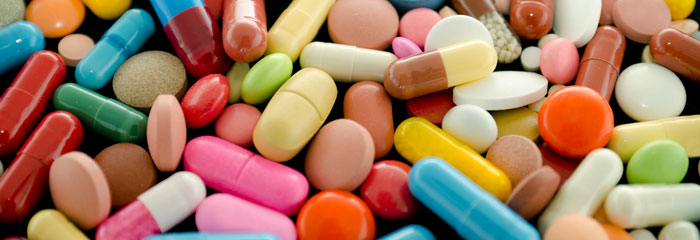

# 💊Drugs Prescription  using reviews

#### Since COVID-19 our medical fraternity is in distress, which results in numerous individuals demise. Due to unavailability, so people independently started taking medicines without proper consult which led to even worse condition. In such case Machine Learning can be useful to build the Prescription  system that uses the reviews of patients using various NLP techniques and recommend the top drug for given disease.


Number of data points: 161,297<br>
Number of unique drugs: 3,436<br>
Number of disease: 884<br>
Timespan: Apr 2008 - Sep 2017<br>
Attributes: 7<br>

Attribute Information:

1. UniuqeID -
2. DrugName - Drug Name
3. Condition - Patient condition
4. review - reviews given by patient after drug consumption
5. ratings - ratings given by patient after drug consumption (0-10)
6. date - Date when review given by patient
7. UsefulCount - Number of patient marked it as useful

Target Var:

1. Drug: Prescribe the best Drug based on sentiment of patients.

### **Objective**:
To build Prescription  model, which help in Prescribing the best drug based on given conditions and sentiment of patients.




## 1. Load Dataset

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import  seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer    # lemmatize
from wordcloud import WordCloud, STOPWORDS
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
#Using Pandas library to load dataset
df = pd.read_csv('/content/drive/MyDrive/Drug_review/drug.csv',
                  engine="python",
                  error_bad_lines=False,
                  encoding='utf-8')

In [97]:
print("Number of data points in our data:", df.shape)
df.head(1)

Number of data points in our data: (161297, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27


In [98]:
df.condition.isnull().sum()

899

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


### 1.2 Check for Missing values

In [100]:
#Let us capture all the nan values
features_nan = [feature for feature in df.columns if df[feature].isnull().sum()>=1]
print("*"*50)
for feature in features_nan:
  print("{}: {}% missing values".format(feature,np.round(df[feature].isnull().mean(),3)*100))
print("*"*50)
print("Data type of those missing nan value features:")
print(df[features_nan].dtypes)

**************************************************
condition: 0.6% missing values
**************************************************
Data type of those missing nan value features:
condition    object
dtype: object


#### Drop Missing Vales

In [101]:
data = df.dropna()

In [102]:
data.shape

(160398, 7)

### 1.3 Basic Statistics (#Drugs, #Condition, and #Ratings)

In [103]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",data.shape[0])
print("Total No of condition   :", len(np.unique(data.condition)))
print("Total No of drug  :", len(np.unique(df.drugName)))

Total data 
--------------------------------------------------

Total no of ratings : 160398
Total No of condition   : 884
Total No of drug  : 3436


# 2. Exploratory Data Analysis

## 1. Ratings

### 2.1 Distribution of ratings

In [104]:
# method to make y-axis more readable
def human(num, units = 'K'):
    units = units.lower()
    num = int(num)
    if units == 'k':
      return str(num/10**3) + " K"

In [105]:
conditions = [
    (data['rating'] > 0) & (data['rating'] <= 6),
    (data['rating'] > 6) & (data['rating'] <= 8),
    (data['rating'] > 8)
]

results = ['Unsatisfied', 'Satisfied','Highly-satisfied']


data['rating_'] = np.select(conditions, results)

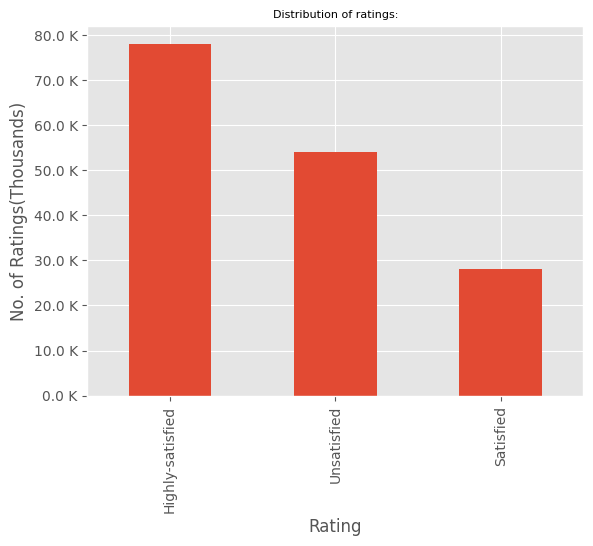

Number of data points in given ratings are  : 78124 ( 48.706 %)
Number of data points in given ratings are  : 54088 ( 33.721 %)
Number of data points in given ratings are  : 28186 ( 17.573 %)


In [106]:
ratings_dist =data.rating_.value_counts()
fig, ax = plt.subplots()
plt.title('Distribution of ratings:', fontsize=8)
ax = data.rating_.value_counts().plot(kind='bar')
ax.set_yticklabels([human(item, 'k') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Thousands)')
ax.set_xlabel('Rating')


plt.show()

sorted_yi = np.argsort(-ratings_dist.values)
for i in sorted_yi:
    print('Number of data points in given ratings are ',':',ratings_dist.values[i], '(', np.round((ratings_dist.values[i]/data.shape[0]*100), 3), '%)')



In [107]:
# 1-5  - unsattisfied
# 6-8 - satisfied/neutral
# 9-10 - Highly satisfied

### 2.3 Number of Ratings per a Year

In [108]:
# It is used to skip the warning ''SettingWithCopyWarning''..
data['day']=data.date.str.split('-').str[0]
data['month']=data.date.str.split('-').str[1]
data['year']=data.date.str.split('-').str[2]

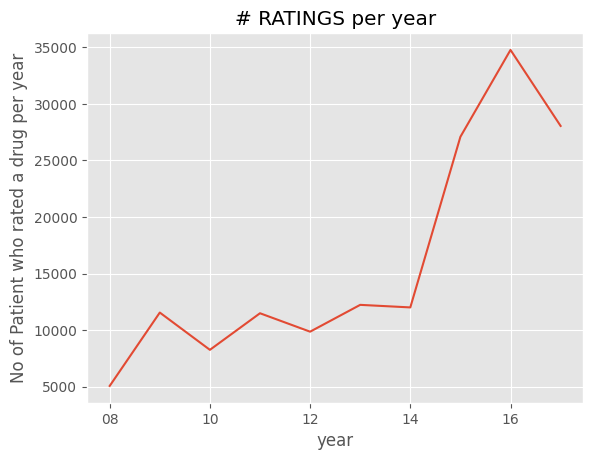

In [109]:
data.groupby(by='year')['rating_'].count().plot()
plt.title('# RATINGS per year')
plt.xlabel('year')
plt.ylabel('No of Patient who rated a drug per year')
# ax.set_xticklabels([])

plt.show()

### 2.3 Univariate Analysis on condition using CDF

In [110]:
unique_condition = data["condition"].value_counts()

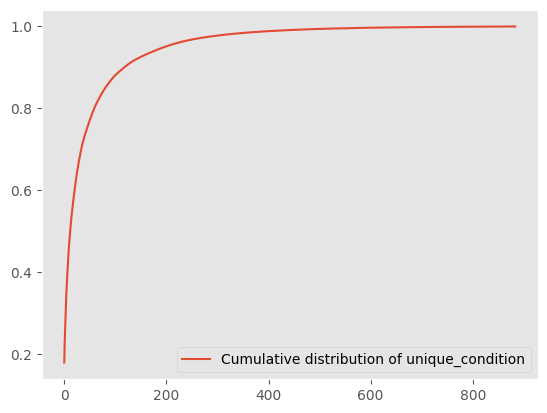

In [111]:
s = sum(unique_condition.values)
h = unique_condition.values/s
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of unique_condition')
plt.grid()
plt.legend()
plt.show()

# label

**Observation**: By looking at CDF it seems that out of 800 unique conditions our 90% of data includes only top (50-75) conditions

### Q1. What is the 6 most frequent illness condition?

Top 6 most frequent illness condition:


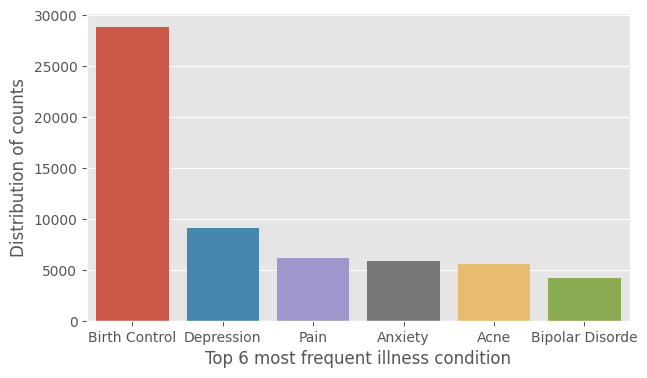

In [112]:
print('Top 6 most frequent illness condition:')
# print(data['condition'].value_counts().nlargest(6))
result = data.condition.value_counts().nlargest(6)
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index)
plt.xlabel('Top 6 most frequent illness condition')
plt.ylabel('Distribution of counts')
plt.gcf().set_size_inches(7,4)

### Q2. What are 4 most frequently suggested drugs for those most frequent condition?

[Text(0.5, 0, 'Drug Name'), Text(0, 0.5, 'Distribution of Drug counts')]

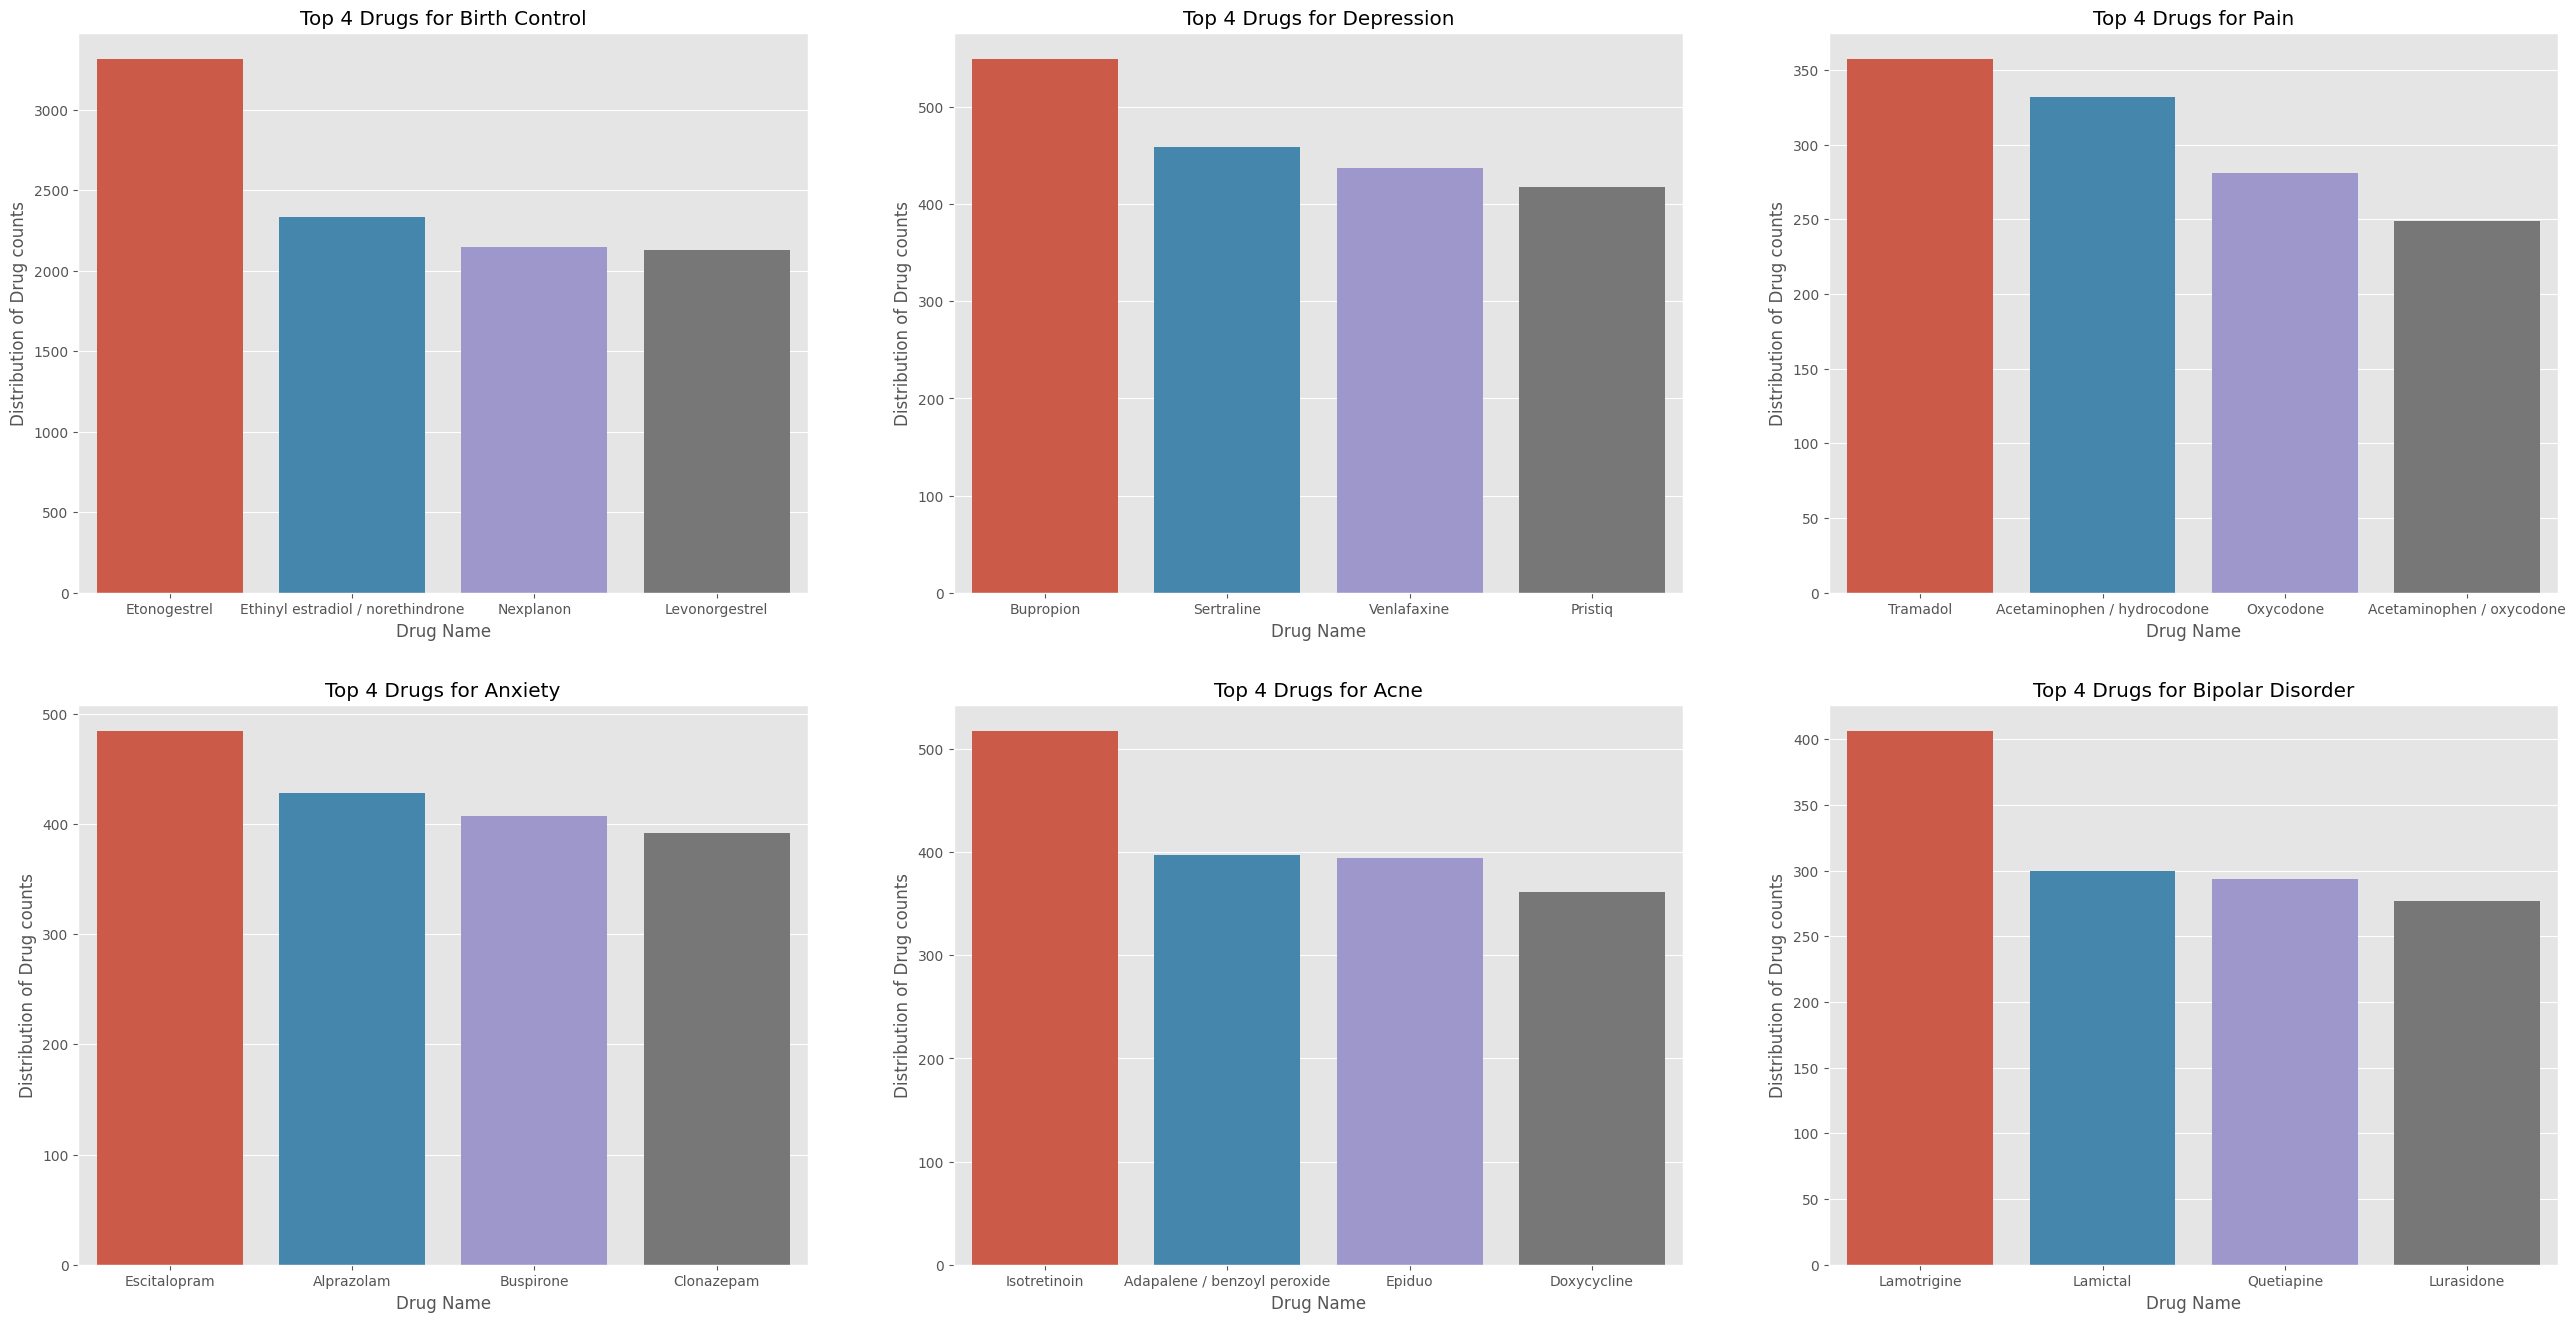

In [113]:
fig, axes = plt.subplots(2, 3, figsize=(32, 16))


br_c =data[data['condition']=='Birth Control']
result = br_c.drugName.value_counts().nlargest(4)
axes[0,0].set_title('Top 4 Drugs for Birth Control')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[0,0])
axes[0,0].set(xlabel='Drug Name', ylabel='Distribution of Drug counts')


d_c =data[data['condition']=='Depression']
result = d_c.drugName.value_counts().nlargest(4)
axes[0,1].set_title('Top 4 Drugs for Depression')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[0,1])
axes[0,1].set(xlabel='Drug Name', ylabel='Distribution of Drug counts')

p_c =data[data['condition']=='Pain']
result = p_c.drugName.value_counts().nlargest(4)
axes[0,2].set_title('Top 4 Drugs for Pain')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[0,2])
axes[0,2].set(xlabel='Drug Name', ylabel='Distribution of Drug counts')

a_c =data[data['condition']=='Anxiety']
result =a_c.drugName.value_counts().nlargest(4)
axes[1,0].set_title('Top 4 Drugs for Anxiety')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[1,0])
axes[1,0].set(xlabel='Drug Name', ylabel='Distribution of Drug counts')

a_c =data[data['condition']=='Acne']
result =a_c.drugName.value_counts().nlargest(4)
axes[1,1].set_title('Top 4 Drugs for Acne')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[1,1])
axes[1,1].set(xlabel='Drug Name', ylabel='Distribution of Drug counts')


b_c =data[data['condition']=='Bipolar Disorde']
result =b_c.drugName.value_counts().nlargest(4)
axes[1,2].set_title('Top 4 Drugs for Bipolar Disorder')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[1,2])
axes[1,2].set(xlabel='Drug Name', ylabel='Distribution of Drug counts')

**Observation**:
- Here we have merged the analysis for top 4 most prescribed drug for top 6 most frequent illness.
- Etonogestral is been prescribed 3000+ times in given dataset for condition BirthControl

### Q3. What is the 5 most Prescribed drugs ?

Top 5 most Prescribed drugs:


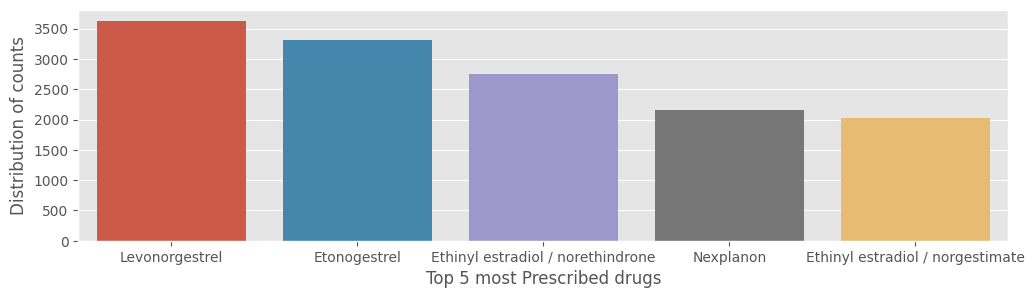

In [114]:
print('Top 5 most Prescribed drugs:')
# print(data['condition'].value_counts().nlargest(6))
result = data.drugName.value_counts().nlargest(5)
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index)
plt.xlabel('Top 5 most Prescribed drugs')
plt.ylabel('Distribution of counts')
plt.gcf().set_size_inches(12,3)

### Q4. What is the 5 most Prescribed drugs per Year? (2014-17)

In [115]:
data['drugName'].value_counts().nlargest(5)

Levonorgestrel                       3631
Etonogestrel                         3321
Ethinyl estradiol / norethindrone    2750
Nexplanon                            2156
Ethinyl estradiol / norgestimate     2033
Name: drugName, dtype: int64

[Text(0.5, 0, 'Drug Name'), Text(0, 0.5, 'Distribution of Drug counts')]

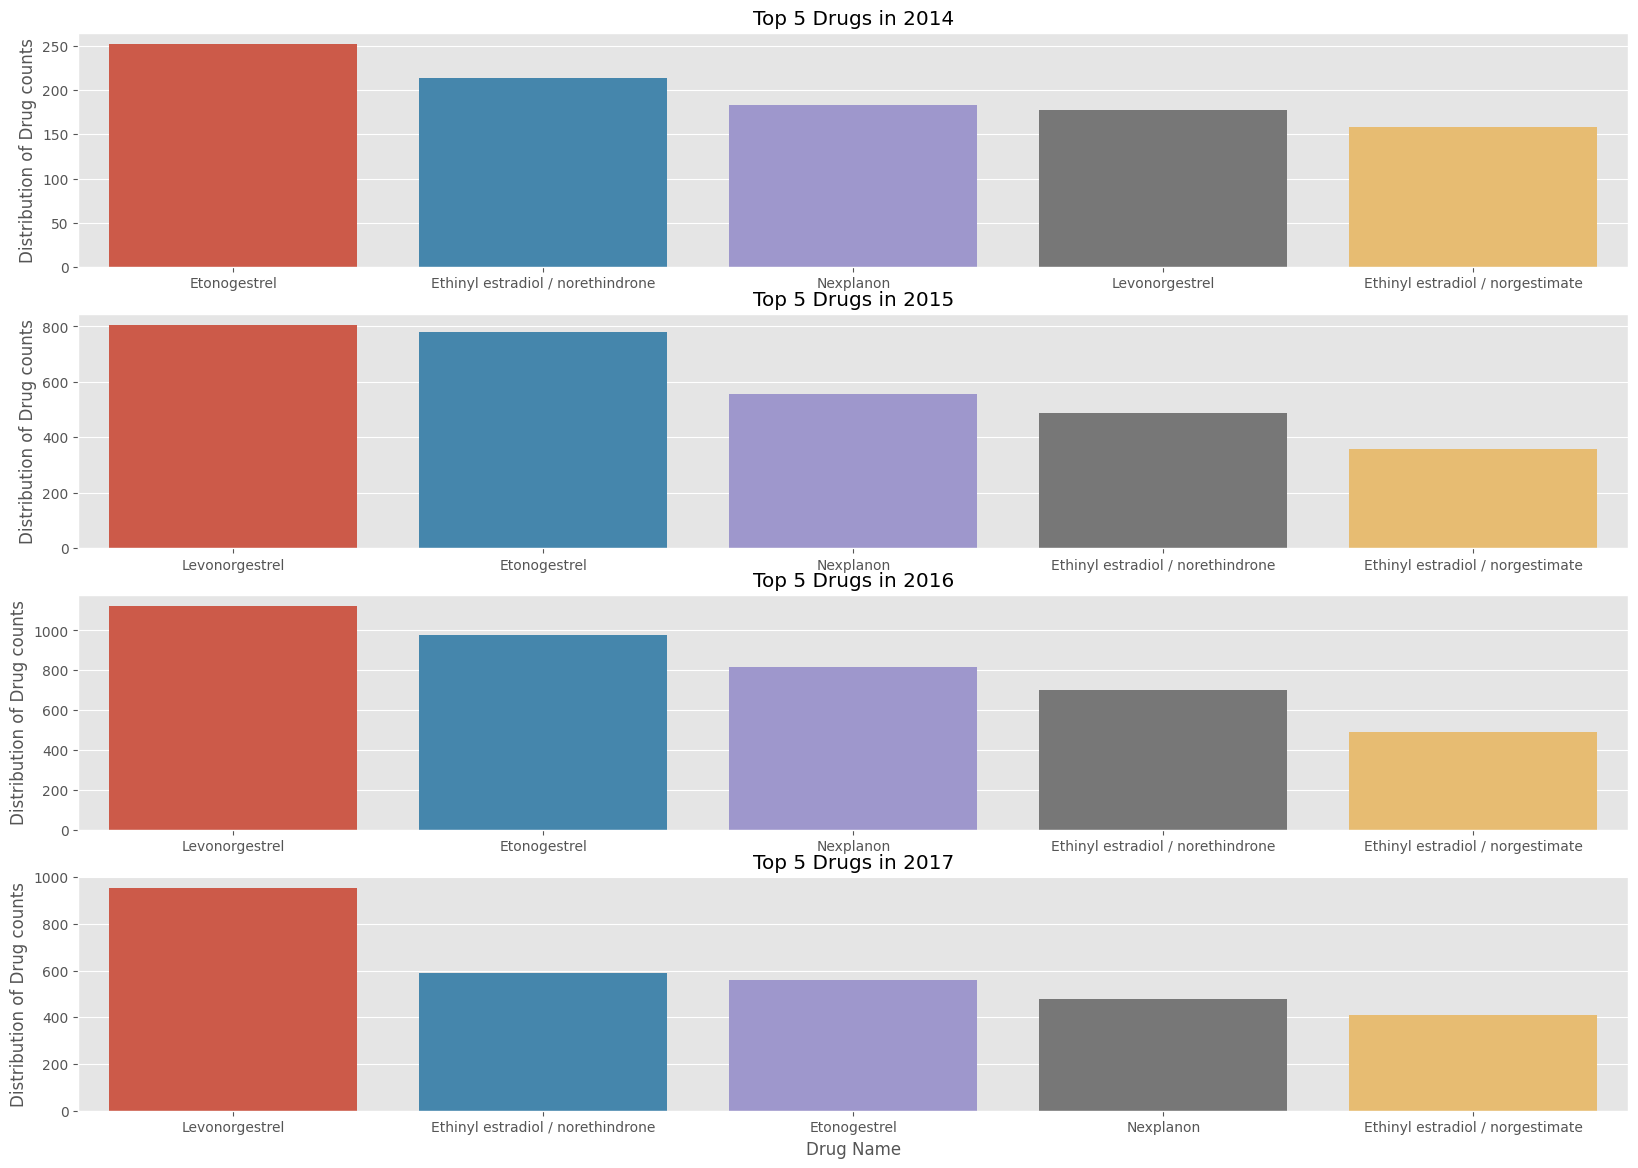

In [116]:
fig, axes = plt.subplots(4, 1, figsize=(20, 14))

first_year=data[data['year']=='14']
result = first_year['drugName'].value_counts().nlargest(5)
axes[0].set_title('Top 5 Drugs in 2014')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[0])
axes[0].set(xlabel=' ', ylabel='Distribution of Drug counts')


second_year=data[data['year']=='15']
result = second_year['drugName'].value_counts().nlargest(5)
axes[1].set_title('Top 5 Drugs in 2015')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[1])
axes[1].set(xlabel=' ', ylabel='Distribution of Drug counts')

third_year=data[data['year']=='16']
result = third_year['drugName'].value_counts().nlargest(5)
axes[2].set_title('Top 5 Drugs in 2016')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[2])
axes[2].set(xlabel=' ', ylabel='Distribution of Drug counts')

fourth_year=data[data['year']=='17']
result = fourth_year['drugName'].value_counts().nlargest(5)
axes[3].set_title('Top 5 Drugs in 2017')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[3])
axes[3].set(xlabel='Drug Name', ylabel='Distribution of Drug counts')


Observation:
- Levonorgestrel & Etonogestrel from past 3 years are most Prescribed Drug.
- In given graph it seems to be as year increase prescribed drug count also increases

### Q5. What is the 5 Highest Voted drugs by patients?

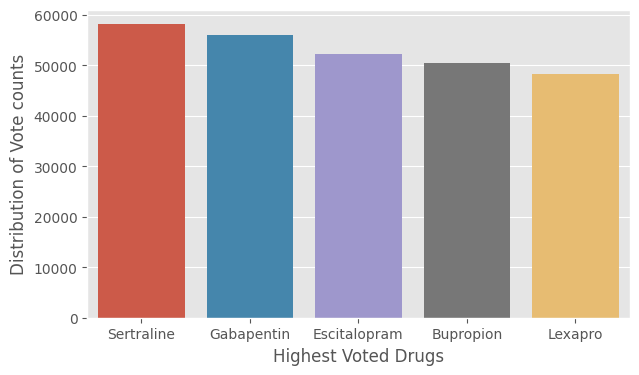

In [117]:
# data.groupby('drugName').agg(Total_views=('usefulCount', np.sum)).
d = data.groupby(['drugName'])['usefulCount'].sum().sort_values(ascending=False).head(5)
#d.plot(kind='bar')
sns.barplot(x=d.index, y=d)
plt.xlabel('Highest Voted Drugs')
plt.ylabel('Distribution of Vote counts')
plt.gcf().set_size_inches(7,4)

**Observation** : This are highest Voted drug by patients overall, but let us check out if all this 5 drug are still most voted in 2017 or not.

### Q5. What is the 5 Highest Voted drugs by patients? (2014-present)

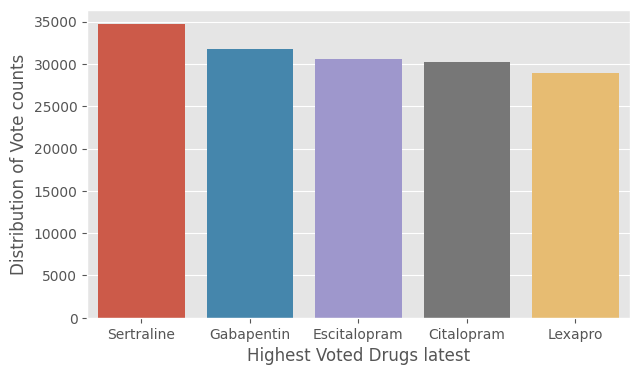

In [118]:
# data.groupby('drugName').agg(Total_views=('usefulCount', np.sum)).
d = data[data['date']>'2013-12-31']
d = d.groupby(['drugName'])['usefulCount'].sum().sort_values(ascending=False).head(5)
#d.plot(kind='bar')
sns.barplot(x=d.index, y=d)
plt.xlabel('Highest Voted Drugs latest')
plt.ylabel('Distribution of Vote counts')
plt.gcf().set_size_inches(7,4)

**Analysis**: Bupropion is been replaced by Phentermine in this category rest are still most voted by patients

### 3.1 Analysis on Useful Count feature

In [119]:
data['usefulCount'].describe()

count    160398.000000
mean         28.097613
std          36.457876
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

**Analysis**:
- Minimum Useful count = 0
- Max useful count = 1291
- Average = 28
- We have to understand more about this feature that what drugs have been most voted and least voted
- For further analyis lets omit last 4 months 2017 because sometime patient need to test the drug before actually voting


### UsefulCount V/S Rating (0-100) quarter range

[Text(0.5, 0, 'rating_'), Text(0, 0.5, 'Distribution of UsefulCount')]

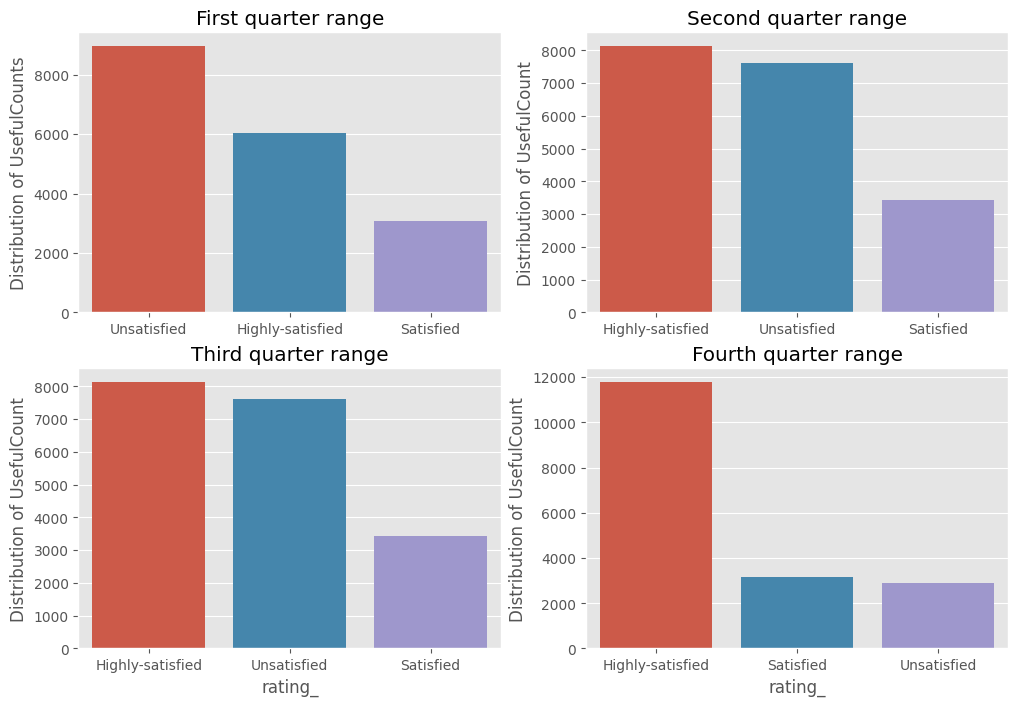

In [120]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

first_qr_useful_c = data[(data['usefulCount'] >= data['usefulCount'].quantile(q=0)) & (data['usefulCount'] <=data['usefulCount'].quantile(q=0.25) )]
first_qr_useful_c = first_qr_useful_c[first_qr_useful_c['date'] < '2017-06-01']

result = first_qr_useful_c.groupby('rating_')['usefulCount'].count()
axes[0,0].set_title('First quarter range')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[0,0])
axes[0,0].set(xlabel='', ylabel='Distribution of UsefulCounts')



second_iqr_useful_c = data[(data['usefulCount'] >= data['usefulCount'].quantile(q=0.25)) & (data['usefulCount'] <=data['usefulCount'].quantile(q=0.50) )]
second_iqr_useful_c = second_iqr_useful_c[second_iqr_useful_c['date'] < '2017-06-01']

result = second_iqr_useful_c.groupby('rating_')['usefulCount'].count()
axes[0,1].set_title('Second quarter range')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[0,1])
axes[0,1].set(xlabel='', ylabel='Distribution of UsefulCount')

third_iqr_useful_c = data[(data['usefulCount'] >= data['usefulCount'].quantile(q=0.50)) & (data['usefulCount'] <=data['usefulCount'].quantile(q=0.75) )]
third_iqr_useful_c = third_iqr_useful_c[third_iqr_useful_c['date'] < '2017-06-01']

result = second_iqr_useful_c.groupby('rating_')['usefulCount'].count()
axes[1,0].set_title('Third quarter range')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[1,0])
axes[1,0].set(xlabel='rating_', ylabel='Distribution of UsefulCount')


fourth_qr_useful_c = data[(data['usefulCount'] >= data['usefulCount'].quantile(q=0.75)) & (data['usefulCount'] <data['usefulCount'].quantile(q=1.0) )]
fourth_qr_useful_c = fourth_qr_useful_c[fourth_qr_useful_c['date'] < '2017-06-01']

result = fourth_qr_useful_c.groupby('rating_')['usefulCount'].count()
axes[1,1].set_title('Fourth quarter range')
sns.barplot(x=result.index, y=result, order=result.sort_values(ascending = False).index,ax=axes[1,1])
axes[1,1].set(xlabel='rating_', ylabel='Distribution of UsefulCount')


**Observation**:
- So here we have merged all 4 quaters analysis w.r.to ratings to see if there is any linear realationship between Ratings v/s Useful counts.
- So as Useful counts increases there is higher ratio of Highly Satisfied patients and lower satisfied patients

In [121]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,rating_,day,month,year
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,Highly-satisfied,20,May,12
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,Satisfied,27,Apr,10
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,Unsatisfied,14,Dec,09
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,Satisfied,3,Nov,15
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,Highly-satisfied,27,Nov,16


## 2. Reviews

### 3.1 Plot Word Clouds
- Creating Word Cloud for Likes i.e (positive / negative reviews)
- We can observe the most frequent occuring words for negative / positive reviews

In [122]:
STOP_WORDS = stopwords.words('english')
stopwords = set(STOP_WORDS)
stopwords.add("I&#039;ve")
stopwords.add("br")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("between")
stopwords.remove("don't")
stopwords.remove("against")
stopwords.add(" ")

### Highly Satisfied Review

In [123]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,rating_,day,month,year
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,Highly-satisfied,20,May,12
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,Satisfied,27,Apr,10
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,Unsatisfied,14,Dec,09
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,Satisfied,3,Nov,15
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,Highly-satisfied,27,Nov,16


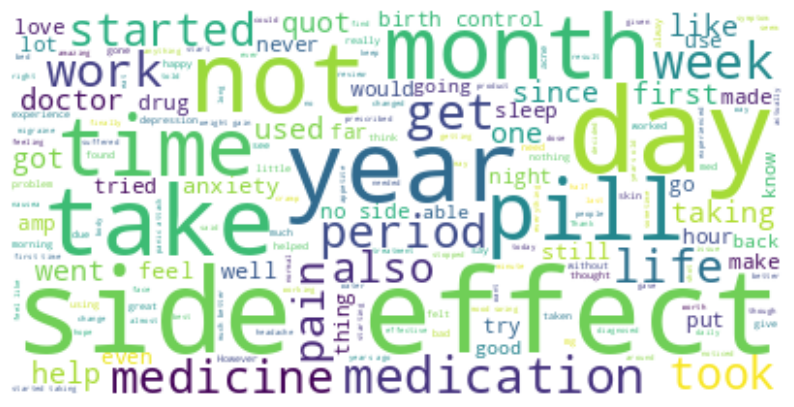

In [124]:
#positive = data.review[[df['rating_']=='Highly-satisfied'].index]
Highly_satisfied = data.review[data['rating_'][data['rating_']=='Highly-satisfied'].index]

plt.figure(figsize = (10,15))
wc = WordCloud(max_words=500,background_color='White',stopwords=stopwords)
wc.generate(" ".join(Highly_satisfied))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

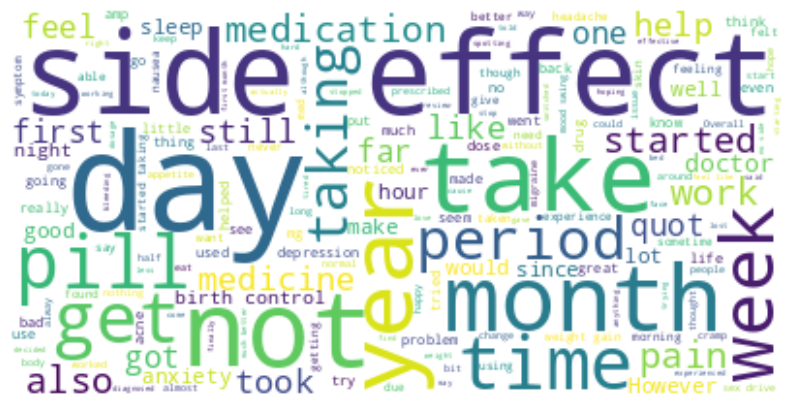

In [125]:
Satisfied = data.review[data['rating_'][data['rating_']=='Satisfied'].index]


plt.figure(figsize = (10,15))
wc = WordCloud(max_words=500,background_color='White',stopwords=stopwords)
wc.generate(" ".join(Satisfied))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

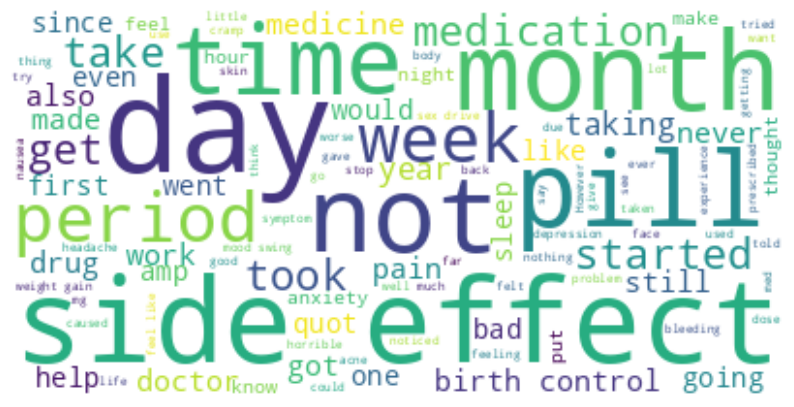

In [126]:
Unsatisfied = data.review[data['rating_'][data['rating_']=='Unsatisfied'].index]


plt.figure(figsize = (10,15))
wc = WordCloud(max_words=500,background_color='White',stopwords=stopwords)
wc.generate(" ".join(Unsatisfied))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 4. Text Preprocessing
- Preprocessing:
- Removing extra characters
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [127]:
data['review'][12567]

'"Why can&#039;t they go back to the old method of making Armour Thyroid? I&#039;ve tried the synthetic meds before. I don&#039;t feel like myself and had msny issues with side effects. Even a mix of two different ones trying to get my t3 right. Tsh levels always good or played games of too high or too low until the t3 was studied. \r\r\nYes I&#039;ve had more issued with sleeping, insomnia, irritability, focus, weight loss, hair loss, and for the first time in my life I had a migraine over a year ago and now needing to take daily meds for them. \r\r\nDoes anyone know of another company even out of the US where we could buy the old formula from.use of pig glands certainly can&#039;t be expensive.just another company filling thier pockets while given a lesser product, we suffer"'

### 4.1.1 Expanding contractions

In [128]:
def text_preproces(x):
    x = str(x).lower()
    x = x.replace('%',' percent').replace('mg',' milligram').replace('dr',' doctor').replace('$',' dollar')\
                                .replace('&#039','').replace('000','k').replace('′',"'").replace("’","'")\
                                .replace("won't","will not").replace("can't",'can not').replace("shouldn't","should not")\
                                .replace("what's",'"what is"').replace("that's",'that is').replace("he's","he is")\
                                .replace("she's","she is").replace("it's","it is").replace("'ve"," have").replace("'re"," are")\
                                .replace("'ll"," will").replace("i'm","i am").replace("n't", " not").replace("10"," ten").replace("25","twenty").replace("5", "five")\
                                .replace("100","hundred").replace("250","two fifty")
    x = re.sub(r'([0-9]+)000',r'\1k',x)

    return x

In [129]:
def extract_features(data):
    data['review'] = data['review'].fillna("").apply(text_preproces)
    print("token features...")

    return data

In [130]:
data = extract_features(data)

token features...


In [131]:
data['review'][12567]

'"why can;t they go back to the old method of making armour thyroid? i;ve tried the synthetic meds before. i don;t feel like myself and had msny issues with side effects. even a mix of two different ones trying to get my t3 right. tsh levels always good or played games of too high or too low until the t3 was studied. \r\r\nyes i;ve had more issued with sleeping, insomnia, irritability, focus, weight loss, hair loss, and for the first time in my life i had a migraine over a year ago and now needing to take daily meds for them. \r\r\ndoes anyone know of another company even out of the us where we could buy the old formula from.use of pig glands certainly can;t be expensive.just another company filling thier pockets while given a lesser product, we suffer"'

### 4.1.2 Removal of HTML tags

In [132]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

data['review']=data['review'].apply(remove_html)

### 4.1.3 Use SentimentIntensityAnalyzer to Analyze reviews

In [133]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [134]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# create get_sentiment function

def get_sentiment(text):

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['pos'] > 0.08 else 0
    # Threshold of 8% pos score

    return sentiment


# apply get_sentiment function

data['sentiment'] = data['review'].apply(get_sentiment)

In [135]:
data.sentiment.value_counts()

1    90020
0    70378
Name: sentiment, dtype: int64

In [136]:
data.rating.value_counts()

10    50745
9     27379
1     21504
8     18791
7      9395
5      7959
2      6879
3      6465
6      6301
4      4980
Name: rating, dtype: int64

### 5. Temporial Data

### 5.1 Age of drug

In [137]:
data['year'] = data['year'].astype(int)
data['Age_in_Year'] = data['year'].max()-data['year']

### 5.2 Time_since_last_presc_in_days = overall_max(date)  - max_date_drug

In [138]:
data['date'] = pd.to_datetime(df['date'])

data['last_time_presc_in_days'] = data.date.max() - data['date']

In [139]:
data.drop(['uniqueID'],axis = 1,inplace = True)

### 5.3 UsefulCount Score for Drug corresponding to given condition

In [140]:
d = data.groupby(['drugName', 'condition']).agg(avg_usefulCount=('usefulCount', np.mean)).reset_index()
df = pd.merge(data, d, how="inner", on=["drugName", "condition"])

### 5.4 Average Rating score for Drug corresponding to given condition


In [141]:
d = data.groupby(['drugName', 'condition']).agg(avg_rating=('rating', np.mean)).reset_index()

df = pd.merge(df, d, how="inner", on=["drugName", "condition"])

In [142]:
conditions = [
    (df['rating'] > 7) & (df['sentiment'] == 1),
    (df['rating'] <=7 ) & (df['sentiment'] == 0),
    (df['rating'] <= 7) & (df['sentiment'] == 1),
    (df['rating'] >7 ) & (df['sentiment'] == 0),
]

sentiment = [1,0,0,1]


df['sentiment_'] = np.select(conditions, sentiment)

In [143]:
df.drop(['sentiment'],axis = 1,inplace =True)

## 6. Feature Scaling

In [144]:
type(df['usefulCount'][0])

numpy.int64

In [145]:
num_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
num_features

['rating',
 'date',
 'usefulCount',
 'year',
 'Age_in_Year',
 'last_time_presc_in_days',
 'avg_usefulCount',
 'avg_rating',
 'sentiment_']

In [146]:
scaling_feat = df[[
 'avg_usefulCount',
 'avg_rating',
 'sentiment_',
 ]]

In [147]:
scaling_feat.head()

,avg_usefulCount,avg_rating,sentiment_
0,29.000000,9.500000,1
1,29.000000,9.500000,1
2,52.831933,5.890756,1
3,52.831933,5.890756,0
4,52.831933,5.890756,0


### MinMaxScaler

In [148]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaled= pd.DataFrame(scaler.fit_transform(scaling_feat),columns = scaling_feat.columns)

### 8.Scoring

In [149]:
df['score'] = (scaled['avg_usefulCount']*0.25+scaled['avg_rating']*0.25+scaled['sentiment_']*0.5)/(0.25+0.25+0.5)
print('max score',df['score'].max())
print('*******************************')
print('min score',df['score'].min())

max score 1.0
*******************************
min score 0.0


In [150]:
df['avg_usefulCount'] = scaled['avg_usefulCount']
df['avg_rating'] = scaled['avg_rating']
df['sentiment_'] = scaled['sentiment_']

df1 = df[['drugName', 'condition', 'score']]


df1 = df1.groupby(['drugName', 'condition']).agg(avg_score=('score', np.mean)).reset_index()

In [151]:
df1['condition']=df1['condition'].str.lower()

In [152]:
condition_list = df1['condition']

unique_conditions =list(set(condition_list.tolist()))

len(unique_conditions)

884

## Conclusion

- So after loading the data we started with EDA process to understand the data through visualizations and also handles outliers and NaN values.In feature engineering we have created some of the features like rating per year,Last time prescribed drug,rating from 1-10.
- With help of Natural language processing we tried to understand the sentiment of patient w.r.t.o drug for given condition and calculated sentiment score (0-1) with help of inbult library sentiment_analyzer in NLP.

### Scoring Process
- After EDA & Feature engineering we scaled the data using MinMax scaler and with important features we have applied scoring process by manually adding weights to each feature and calculated score.
- After that we build the recommender system where by inserting the given condition it will provide top 5 best drugs with higher scores.

In [173]:
a = input("Enter the illness Condition:")
if a in unique_conditions:
  condition = df1[['drugName','avg_score']].loc[df1['condition'] == a]
  top_scores = condition.sort_values(['avg_score'], ascending=[False])
  final = top_scores['drugName'].head(5)
  print('Top 5 drugs for',a,'are :',final.values.tolist())
else:
  print("There are no available drug for the given illness below")

Enter the illness Condition:pain
Top 5 drugs for pain are : ['Oxyfast', 'Ultram ODT', 'Dolophine', 'Roxicodone Intensol', 'Methadone Diskets']
